In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [22]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## load data from files
splits them from each folders

In [23]:
dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    "../data/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 41276 files belonging to 16 classes.


In [24]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'PlantVillage',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [25]:
len(dataset)

1290

(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 11 10 11
  9  2  2  2  9  3  1  8]
(256, 256, 3)
(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 11 10 11
  9  2  2  2  9  3  1  8]
(256, 256, 3)
(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 11 10 11
  9  2  2  2  9  3  1  8]
(256, 256, 3)
(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 11 10 11
  9  2  2  2  9  3  1  8]
(256, 256, 3)
(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 11 10 11
  9  2  2  2  9  3  1  8]
(256, 256, 3)
(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 11 10 11
  9  2  2  2  9  3  1  8]
(256, 256, 3)
(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 11 10 11
  9  2  2  2  9  3  1  8]
(256, 256, 3)
(32, 256, 256, 3)
[12  4 10  2 13 10  2  6  2 15  3  2  2  7  6  2  4 12 11  9  2 1

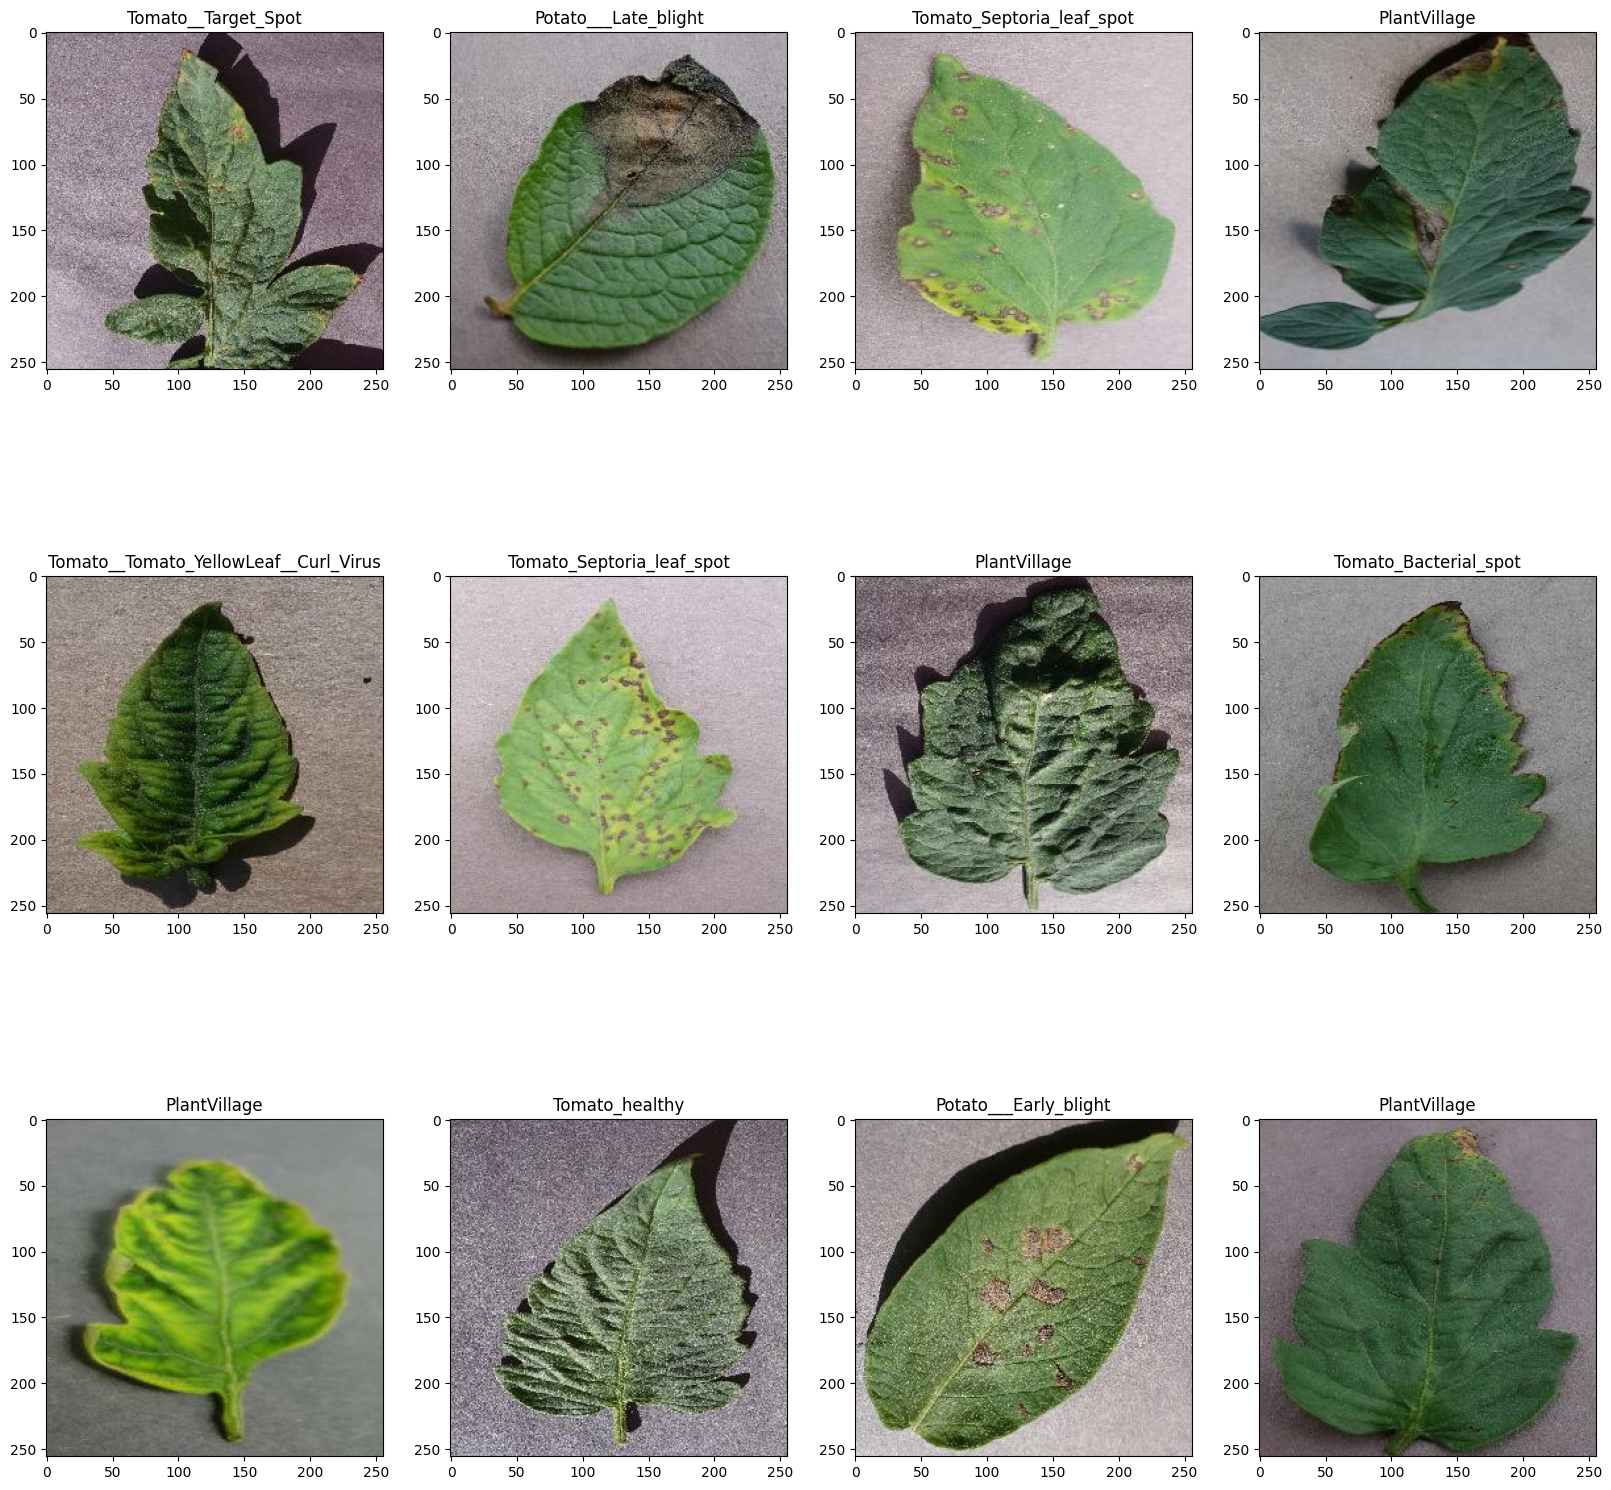

In [26]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        print(image_batch.shape)
        print(label_batch.numpy())
        print(image_batch[0].shape)
    #     plottig the images 
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))

## Start train test split

In [27]:
train_size = 0.8
dataset.take(10)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
train_sets = len(dataset)* train_size

### Calculate data for train and split

In [29]:
train_dataset = dataset.take(int(train_sets))
len(train_dataset)

1032

In [30]:
test_dataset = dataset.skip(int(train_sets))
len(test_dataset)

258

In [31]:
validation_size = 0.1
len(dataset)*validation_size

129.0

In [32]:
validation_dataset = test_dataset.take(64)
len(validation_dataset)

64

In [33]:
act_test_dataset = test_dataset.skip(64)

In [34]:
def get_dataset_partitions_to_tf(dataset, train_split=0.8, test_split=0.1,validation_split=0.1,shuffle=True,shuffle_size=1000):
    
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split* dataset_size)
    validation_size = int(validation_split * dataset_size)
    
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    return train_dataset, validation_dataset, test_dataset
    

In [35]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_to_tf(dataset)

In [36]:
len(train_dataset)

1032

In [37]:
len(validation_dataset)

129

In [38]:
len(test_dataset)

129

## Improve training performance base on caching

In [45]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
resize_and_resacle = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [47]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Building Model
using CNN, since we are going for image classification 

In [53]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_resacle,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape= (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape= (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape= (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape= (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape= (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape= input_shape)

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

## CNN architecture

In [62]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose =1,
    validation_data=validation_dataset
)

Epoch 1/50
